## Mecanismo de atenção

In [290]:
import torch
import numpy as np

from utils import plot_tensors_2d
torch.manual_seed(42)

#### Motivação

"Joana não atravessou a estrada porque ela estava"
####
| Token      | Col 1 | Col 2 | Col 3 | Col 4 | Col 5 | Col 6 | Col 7 | Col 8 |
|:-----------|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Joana      | 1     | 0     | 0     | 0     | 0     | 0     | 0     | 0     |
| não        | 0     | 1     | 0     | 0     | 0     | 0     | 0     | 0     |
| atravessou | 0     | 0     | 1     | 0     | 0     | 0     | 0     | 0     |
| a          | 0     | 0     | 0     | 1     | 0     | 0     | 0     | 0     |
| estrada    | 0     | 0     | 0     | 0     | 1     | 0     | 0     | 0     |
| porque     | 0     | 0     | 0     | 0     | 0     | 1     | 0     | 0     |
| ela        | 0     | 0     | 0     | 0     | 0     | 0     | 1     | 0     |
| estava     | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 1     |

#### O ideal seria ter uma representação numérica que capturasse o sentido da palavra "ela" no contexto da frase anterior. 

Por exemplo:

"Joana não atravessou a estrada porque ela estava"

| Token      | Col 1 | Col 2 | Col 3 | Col 4 | Col 5 | Col 6 | Col 7 | Col 8 |
|:-----------|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Joana      | 1     | 0     | 0     | 0     | 0     | 0     | 0     | 0     |
| não        | 0     | 1     | 0     | 0     | 0     | 0     | 0     | 0     |
| atravessou | 0     | 0     | 1     | 0     | 0     | 0     | 0     | 0     |
| a          | 0     | 0     | 0     | 1     | 0     | 0     | 0     | 0     |
| estrada    | 0     | 0     | 0     | 0     | 1     | 0     | 0     | 0     |
| porque     | 0     | 0     | 0     | 0     | 0     | 1     | 0     | 0     |
| ela        | 0.3     | 0     | 0     | 0     | 0.3     | 0     | 0.4     | 0     |
| estava     | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 1     |

In [291]:
X = torch.tensor([[1., 0., 0., 0., 0., 0., 0., 0.],    # "Joana"
                  [0., 1., 0., 0., 0., 0., 0., 0.],    # "não"
                  [0., 0., 1., 0., 0., 0., 0., 0.],    # "atravessou"
                  [0., 0., 0., 1., 0., 0., 0., 0.],    # "a"
                  [0., 0., 0., 0., 1., 0., 0., 0.],    # "estrada"
                  [0., 0., 0., 0., 0., 1., 0., 0.],    # "porque"
                  [0., 0., 0., 0., 0., 0., 1., 0.],    # "ela"
                  [0., 0., 0., 0., 0., 0., 0., 1.]]    # "estava"
).float()

print(f'Antes da atenção: \n')
print(X.numpy())

Antes da atenção: 

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [292]:
attention = torch.tensor([
                [1., 0., 0., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0., 0., 0.],
                [0., 0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 0., 1., 0., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 0., 0., 1., 0., 0.],
                [0.3, 0., 0., 0., 0.3, 0., 0.4, 0.],    # mapa de atenção para a palavra "ela"
                [0., 0., 0., 0., 0., 0., 0., 1.]
]).float()


print(f'Depois da atenção: \n')
print((attention @ X).numpy())

Depois da atenção: 

[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.3 0.  0.  0.  0.3 0.  0.4 0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


### Scaled Dot-Product Attention

$$
\text{Atenção}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [293]:
TAMANHO_SEQUENCIA = 3       # tamanho máximo de cada sequência
DIMENSAO_EMBEDDINGS = 3     # tamanho da representação numérica de cada parte de uma sequência

#### Representação numérica de palavras:
"Olá Mundo!"
####
| Token  | Col 1 | Col 2 | Col 3 | Col 4 |
|:------|:-----:|:-----:|:-----:|------:|
| Olá   | 0     | 1     | 2     | 3     |
| Mundo | -2    | 4     | 0     | -5    |
| !     | 0     | 0     | 0     | -1    |


In [294]:
X = torch.tensor([
    [1, 0, 0],    # "Olá"
    [0, 1, 0],  # "Mundo"
    [0, 0, 1]    # "!"
]).float()
X, X.shape

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
 torch.Size([3, 3]))

In [295]:
linear_q = torch.randn(DIMENSAO_EMBEDDINGS, DIMENSAO_EMBEDDINGS)
linear_v = torch.randn(DIMENSAO_EMBEDDINGS, DIMENSAO_EMBEDDINGS)
linear_k = torch.randn(DIMENSAO_EMBEDDINGS, DIMENSAO_EMBEDDINGS)

Q = torch.matmul(X, linear_q) 
K = torch.matmul(X, linear_k)
V = torch.matmul(X, linear_v)

X.shape, Q.shape, K.shape, V.shape

(torch.Size([3, 3]),
 torch.Size([3, 3]),
 torch.Size([3, 3]),
 torch.Size([3, 3]))

#### O produto escalar é uma medida de similaridade entre dois vetores:

$$
\vec{q_i} \cdot \vec{k_i} = \|\vec{q_i}\| \|\vec{k_i}\| \cos(\theta)
$$

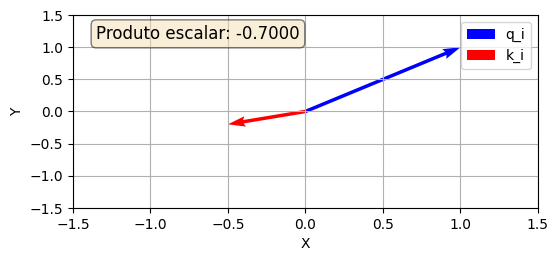

In [296]:
q_i = torch.tensor([1, 1]).float()
k_i = torch.tensor([-0.5, -0.2]).float()
plot_tensors_2d(q_i, k_i, q_i @ k_i)

In [297]:
q_k = torch.matmul(Q, K.transpose(-2, -1))
q_k

tensor([[-0.0374,  0.3752,  0.2246],
        [ 0.4144,  0.3780, -0.0956],
        [-0.5878,  2.0916,  0.8271]])

In [298]:
attention = q_k / torch.sqrt(torch.tensor([DIMENSAO_EMBEDDINGS]))
attention

tensor([[-0.0216,  0.2167,  0.1297],
        [ 0.2393,  0.2182, -0.0552],
        [-0.3394,  1.2076,  0.4775]])

In [299]:
attention = torch.softmax(attention, dim=-1)
attention

tensor([[0.2913, 0.3697, 0.3389],
        [0.3671, 0.3595, 0.2735],
        [0.1256, 0.5901, 0.2843]])

In [300]:
attention @ X

tensor([[0.2913, 0.3697, 0.3389],
        [0.3671, 0.3595, 0.2735],
        [0.1256, 0.5901, 0.2843]])